# 03 - Clustering y Perfilado de Clientes

En este notebook se realiza:

1. Escalamiento de variables numéricas.
2. Selección de número de clusters usando Silhouette.
3. Entrenamiento de KMeans.
4. Visualización (PCA, boxplots, heatmap de centroides).
5. Creación de perfiles de segmentos de cliente.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.style.use("ggplot")

df = pd.read_csv("../data/processed/customer_features.csv", index_col=0)

numeric_cols = [
    "frequency","monetary","avg_ticket","max_ticket",
    "std_ticket","n_products","recency_days","tenure_days"
]

df[numeric_cols].head()


,frequency,monetary,avg_ticket,max_ticket,std_ticket,n_products,recency_days,tenure_days
CustomerID,,,,,,,,
12346,12,77556.46,6463.038333,77183.6,13234.943418,27,325,400
12347,8,5633.32,704.165000,249.6,20.609093,126,1,402
12348,5,2019.40,403.880000,240.0,44.205549,25,74,362
12349,4,4428.69,1107.172500,300.0,33.761403,138,18,570
12350,1,334.40,334.400000,40.0,7.275538,17,309,0


In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])


In [3]:
sil_scores = {}

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")


k=2, silhouette=0.9801
k=3, silhouette=0.4006
k=4, silhouette=0.4053
k=5, silhouette=0.3612
k=6, silhouette=0.3985
k=7, silhouette=0.3989
k=8, silhouette=0.3990
k=9, silhouette=0.3990
k=10, silhouette=0.3808


Se elige el valor de `k` que presente un **Silhouette Score** relativamente alto
y que mantenga interpretabilidad (típicamente entre 3 y 6 clusters).


In [4]:
k_opt = 4  # ajusta según el resultado de Silhouette

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts().sort_index()


cluster
0    3337
1    2526
2       1
3      14
Name: count, dtype: int64

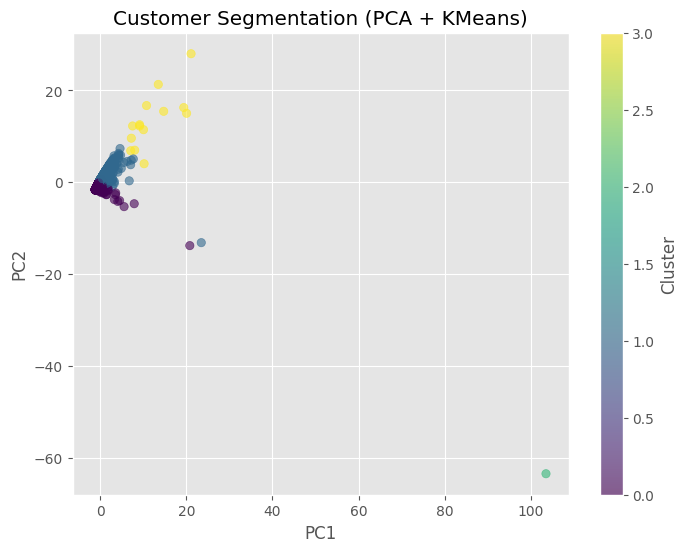

In [5]:
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(pc[:,0], pc[:,1], c=df["cluster"], cmap="viridis", alpha=0.6)
plt.title("Customer Segmentation (PCA + KMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [6]:
cluster_profile = df.groupby("cluster")[numeric_cols].mean()
cluster_profile


,frequency,monetary,avg_ticket,max_ticket,std_ticket,n_products,recency_days,tenure_days
cluster,,,,,,,,
0,2.148037,744.469860,348.764181,110.442910,26.479182,34.601438,310.306263,76.650584
1,10.821853,4791.524776,408.118941,210.856065,31.047171,138.773555,56.224861,530.038797
2,2.000000,168472.500000,84236.250000,168469.600000,97265.131753,3.000000,0.000000,204.000000
3,175.928571,213376.369286,1685.558685,2087.485714,175.472378,1137.285714,2.500000,711.500000


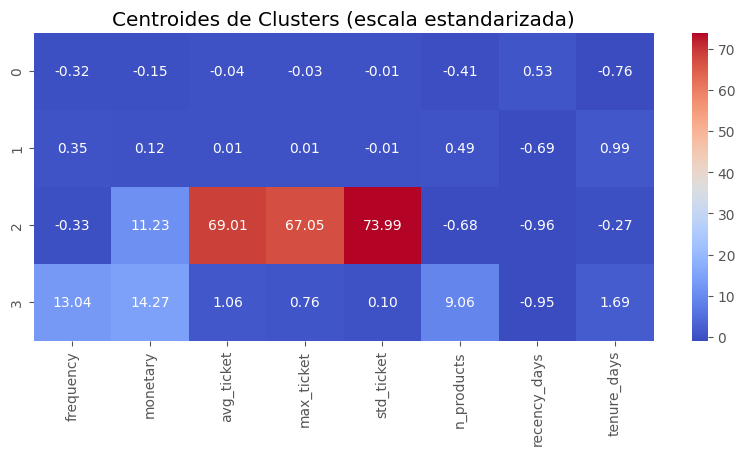

In [7]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_cols)

plt.figure(figsize=(10,4))
sns.heatmap(centroids, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Centroides de Clusters (escala estandarizada)")
plt.show()


A partir del perfil medio por cluster se pueden definir segmentos como, por ejemplo:

- **Cluster 0 – Clientes Premium Frecuentes**: alta `frequency`, alto `monetary`, baja `recency_days`.
- **Cluster 1 – Ocasionales de Ticket Alto**: baja `frequency`, alto `avg_ticket` y `max_ticket`.
- **Cluster 2 – Clientes Dormidos**: baja `frequency` y `monetary`, alta `recency_days`.
- **Cluster 3 – Diversificados Moderados**: `n_products` alto, frecuencia media, `monetary` medio.

Estos nombres pueden ajustarse según los resultados concretos.


In [8]:
## Guardar resultados
df.to_csv("../reports/customer_segments_summary.csv")
cluster_profile.to_csv("../reports/cluster_profile_means.csv")
